To prevent **Overfitting** use a more simpler model, a more complete training data, and when not possible, use *regularization*.

*Note: **Underfitting** may happen when the model is not powerful enough, is over-regularized, or has simply not been trained long enough.*

In [1]:
import tensorflow as tf
import numpy as np

import pathlib
import shutil
import tempfile

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

from tensorflow.keras import layers
from tensorflow.keras import regularizers

from IPython import display
from matplotlib import pyplot as plt

In [2]:
print(tf.__version__)

2.12.0


In [3]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [4]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

2816407858/2816407858 [==============================] - 161s 0us/step


In [5]:
FEATURES = 28
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

In [7]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

In [8]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


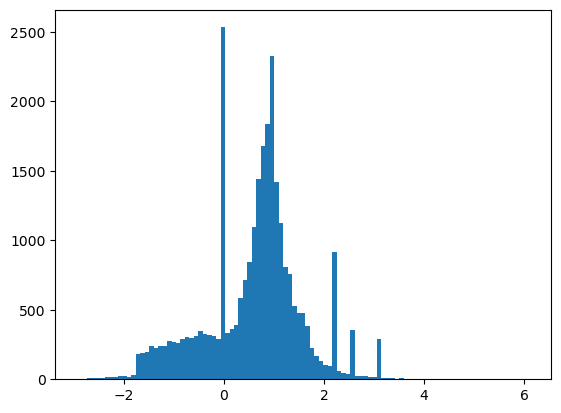

In [10]:
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

In [11]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [13]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

## Modeling Overfitting

Generic code, always run the same training configurations

In [21]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

We are going to monitor the **binary_crossentropy** because the **loss** is affected by the techniques that wea are goint to use to deal with overfitting.

In [16]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

In [19]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
    if optimizer is None:
        optimizer = get_optimizer()

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[
            tf.keras.metrics.BinaryCrossentropy(from_logits=True, name='binary_crossentropy'),
            'accuracy'
        ]
    )
    
    model.summary()

    history = model.fit(
        train_ds,
        steps_per_epoch = STEPS_PER_EPOCH,
        epochs=max_epochs,
        validation_data=validate_ds,
        callbacks=get_callbacks(name),
        verbose=0
    )
    
    return history

In [ ]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

### Models

In [33]:
# input_shape is only required here so that `.summary` works.
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])
small_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

In [34]:
size_histories = {}

In [35]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")
size_histories['large'] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 16)                464       
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5024,  binary_crossentropy:0.7748,  loss:0.7748,  val_accuracy:0.4780,  val_binary_crossentropy:0.7406,  val_loss:0.7406,  
....................................................................................................
Epoch: 100, accuracy:0.5968,  binary_crossentropy:0.6250,  loss:0.6250,  val_accuracy:0.5880,  val_binary_crossentropy:0.6286,  val_loss:0.6286,  
..........................................................

From **Tensorflow**:
- If both metrics are moving in the same direction, everything is fine.
- If the validation metric begins to stagnate while the training metric continues to improve, you are probably close to overfitting.
- If the validation metric is going in the wrong direction, the model is clearly overfitting.

Is clear that the only one that avoids overfitting is the *Tiny* model

Text(0.5, 0, 'Epochs [Log Scale]')

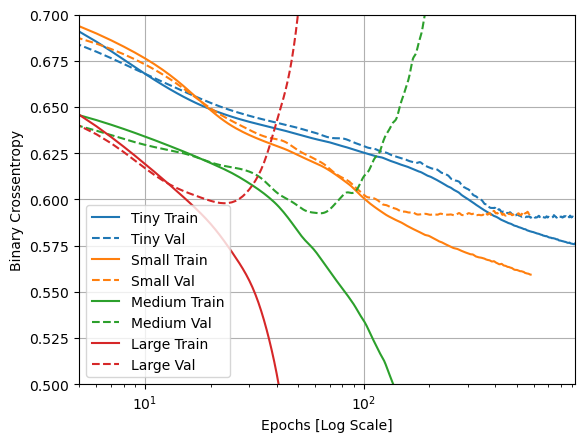

In [38]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

## Avoid Overfitting

In [39]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

WindowsPath('C:/Users/joao/AppData/Local/Temp/tmpo4qfx6oy/tensorboard_logs/regularizers/Tiny')

### Regularization

From **Tensorflow**:

- L1 regularization: where the cost added is proportional to the absolute value of the weights coefficients.
- 
L2 regularization, where the cost added is proportional to the square of the value of the weights coefficiens). L2 regularization is also called weight decay in the context of neural network

Optimizers like `tf.keras.optimizers.Ftrl` and `tfa.optimizers.AdamW` use *decoupled weight decay*, meaning that the optimizers make the calculations using the raw **loss** (without regularization), the decay in weights is applied when updating the step.n.

In [49]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']
regularizer_histories['large'] = size_histories['large']

In [50]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001), input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

From **Tensorflow**:

`l2(0.001)` means that every coefficient in the weight matrix of the layer will add `0.001 * weight_coefficient_value**2` to the total **loss** of the network.

That is why were monitoring the **binary_crossentropy** directly. Because it doesn't have this regularization component mixed in.

In [51]:
regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 512)               14848     
                                                                 
 dense_28 (Dense)            (None, 512)               262656    
                                                                 
 dense_29 (Dense)            (None, 512)               262656    
                                                                 
 dense_30 (Dense)            (None, 512)               262656    
                                                                 
 dense_31 (Dense)            (None, 1)                 513       
                                                                 
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5093,  binary_crossentropy

### Dropout

Dropout, applied to a layer, consists of randomly "dropping out" (i.e. set to zero) a number of output features of the layer during training

In [53]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

In [54]:
regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 512)               14848     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_33 (Dense)            (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_34 (Dense)            (None, 512)               262656    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_35 (Dense)            (None, 512)              

### Combined L2 + Dropout

In [55]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

In [56]:
regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_37 (Dense)            (None, 512)               14848     
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_38 (Dense)            (None, 512)               262656    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_39 (Dense)            (None, 512)               262656    
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_40 (Dense)            (None, 512)             

## Results

Text(0.5, 0, 'Epochs [Log Scale]')

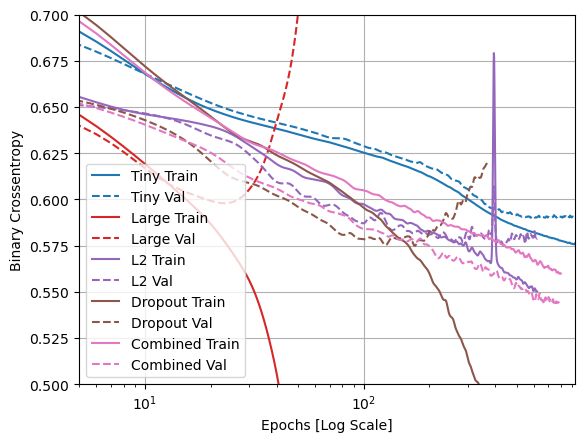

In [57]:
plotter.plot(regularizer_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

To prevent overfitting:

- Get more training datata
- Reduce the capacity of the network
- Add weight regularization
- Add dropout

Also:
- Data augmentation: increase instance size
- Batch normalization

### Batch normalization:
Normalizes the output of a layer around a mean learned during training, it is usually added as an aid to the optimization process (though it can sometimes also help prediction performance). Models with batchnorm tend to need fewer epochs to complete training. Moreover, batchnorm can also fix various problems that can cause the training to get "stuck". Dropout and Batch Normalization often lead to a worse performance when they are combined together.